In [1]:
import re
import pprint
import numpy as np
import sympy as sp
import openturns as ot
import matplotlib.pyplot as plt
import trimesh as tr

from math import pi
from joblib import Parallel, delayed
from importlib import reload
from IPython.display import display
from time import time
from sympy.printing import latex
from trimesh import viewer as trview

import iota

ar = np.array

# **Dans ce Notebook, on analysera le système simple hyperstatique 2D en utlisant la méthode basée sur une représentation matricielle du mécanisme, version automatique.** 

#### **Définition des grandeurs nominales de la pièce**

In [2]:
hM = 10
hF = 10.2
L1 = 30
L2 = 70
L3 = L1
lM = 10
lF = 10.2

#### **Définition du repère global R0 / qui est aussi un repère local de la pièce fixe.**

#### **Définisson les coordonnées des points charactéristiques de chaque surface de chaque pièce.**

In [3]:
# Pièce 1 (male)
P1A0, P1A1, P1A2 = (
    ar((L1 - lM / 2, hM / 2, 0.0)),
    ar((L1 - lM / 2, 0, 0.0)),
    ar((L1 - lM / 2, hM, 0.0)),
)
P1B0, P1B1, P1B2 = (
    ar((L1 + lM / 2, hM / 2, 0.0)),
    ar((L1 + lM / 2, 0, 0.0)),
    ar((L1 + lM / 2, hM, 0.0)),
)
P1C0, P1C1, P1C2 = (
    ar((L1 + L2 - lM / 2, hM / 2, 0.0)),
    ar((L1 + L2 - lM / 2, 0, 0.0)),
    ar((L1 + L2 - lM / 2, hM, 0.0)),
)
P1D0, P1D1, P1D2 = (
    ar((L1 + L2 + lM / 2, hM / 2, 0.0)),
    ar((L1 + L2 + lM / 2, 0, 0.0)),
    ar((L1 + L2 + lM / 2, hM, 0.0)),
)
P1E0, P1E1 = ar((0.0, 0.0, 0.0)), ar((L1 + L2 + L3, 0.0, 0.0))

# Pièce 2 (femelle)  # On met les points à hM et pas hF pour qu'ils soient bien oposées! (Besoin??)
P2A0, P2A1, P2A2 = (
    ar((L1 - lF / 2, hF / 2, 0.0)),
    ar((L1 - lF / 2, 0, 0.0)),
    ar((L1 - lF / 2, hF, 0.0)),
)
P2B0, P2B1, P2B2 = (
    ar((L1 + lF / 2, hF / 2, 0.0)),
    ar((L1 + lF / 2, 0, 0.0)),
    ar((L1 + lF / 2, hF, 0.0)),
)
P2C0, P2C1, P2C2 = (
    ar((L1 + L2 - lF / 2, hF / 2, 0.0)),
    ar((L1 + L2 - lF / 2, 0, 0.0)),
    ar((L1 + L2 - lF / 2, hF, 0.0)),
)
P2D0, P2D1, P2D2 = (
    ar((L1 + L2 + lF / 2, hF / 2, 0.0)),
    ar((L1 + L2 + lF / 2, 0, 0.0)),
    ar((L1 + L2 + lF / 2, hF, 0.0)),
)
P2E0, P2E1 = ar((0.0, 0.0, 0.0)), ar((L1 + L2 + L3, 0.0, 0.0))

In [4]:
#### **Définisson les repères locaux de chaque surface substituée.**

In [5]:
R0 = ar([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x_, y_, z_ = R0[0], R0[1], R0[2]

# Pièce1
RP1b = RP1d = R0
RP1a = RP1c = ar([-x_, -y_, z_]).T
RP1e = ar([y_, -x_, z_]).T

# Pièce2
RP2a = RP2c = R0
RP2b = RP2d = ar([-x_, -y_, z_]).T
RP2e = ar([-y_, x_, z_]).T

#### Maintenant construisons les matrices de transformation pour passer du repère global aux repères locaux (et de définition des matrices de déviation et Jeu! )

    tfrt : transformation from rotation translation

In [6]:
TP1cC0, TP1cC1, TP1cC2 = (
    iota.tfrt(RP1c, P1C0),
    iota.tfrt(RP1c, P1C1),
    iota.tfrt(RP1c, P1C2),
)
TP1aA0, TP1aA1, TP1aA2 = (
    iota.tfrt(RP1a, P1A0),
    iota.tfrt(RP1a, P1A1),
    iota.tfrt(RP1a, P1A2),
)
TP1bB0, TP1bB1, TP1bB2 = (
    iota.tfrt(RP1b, P1B0),
    iota.tfrt(RP1b, P1B1),
    iota.tfrt(RP1b, P1B2),
)
TP1dD0, TP1dD1, TP1dD2 = (
    iota.tfrt(RP1d, P1D0),
    iota.tfrt(RP1d, P1D1),
    iota.tfrt(RP1d, P1D2),
)
TP1eE0, TP1eE1 = iota.tfrt(RP1e, P1E0), iota.tfrt(RP1e, P1E1)
TP2aA0, TP2aA1, TP2aA2 = (
    iota.tfrt(RP2a, P2A0),
    iota.tfrt(RP2a, P2A1),
    iota.tfrt(RP2a, P2A2),
)
TP2cC0, TP2cC1, TP2cC2 = (
    iota.tfrt(RP2c, P2C0),
    iota.tfrt(RP2c, P2C1),
    iota.tfrt(RP2c, P2C2),
)
TP2bB0, TP2bB1, TP2bB2 = (
    iota.tfrt(RP2b, P2B0),
    iota.tfrt(RP2b, P2B1),
    iota.tfrt(RP2b, P2B2),
)
TP2dD0, TP2dD1, TP2dD2 = (
    iota.tfrt(RP2d, P2D0),
    iota.tfrt(RP2d, P2D1),
    iota.tfrt(RP2d, P2D2),
)
TP2eE0, TP2eE1 = iota.tfrt(RP2e, P2E0), iota.tfrt(RP2e, P2E1)

In [7]:
system_data = {
    "PARTS": {
        "1": {
            "a": {
                "FRAME": RP1a,
                "TYPE": "plane",
                "CONSTRAINTS_D": ["NONE"],
                "POINTS": {"A0": P1A0, "A1": P1A1, "A2": P1A2},
                "INTERACTIONS": ["P2a"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "b": {
                "FRAME": RP1b,
                "TYPE": "plane",
                "CONSTRAINTS_D": ["NONE"],
                "POINTS": {"B0": P1B0, "B1": P1B1, "B2": P1B2},
                "INTERACTIONS": ["P2b"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "c": {
                "FRAME": RP1c,
                "TYPE": "plane",
                "CONSTRAINTS_D": ["NONE"],
                "POINTS": {"C0": P1C0, "C1": P1C1, "C2": P1C2},
                "INTERACTIONS": ["P2c"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "d": {
                "FRAME": RP1d,
                "TYPE": "plane",
                "CONSTRAINTS_D": ["NONE"],
                "POINTS": {"D0": P1D0, "D1": P1D1, "D2": P1D2},
                "INTERACTIONS": ["P2d"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "e": {
                "FRAME": RP1e,
                "TYPE": "plane",
                "CONSTRAINTS_D": ["PERFECT"],
                "POINTS": {"E0": P1E0, "E1": P1E1},
                "INTERACTIONS": ["P2e"],
                "CONSTRAINTS_G": ["SLIDING"],
            },
        },
        "2": {
            "a": {
                "FRAME": RP2a,
                "TYPE": "plane",
                "CONSTRAINTS_D": ["NONE"],
                "POINTS": {"A0": P2A0, "A1": P2A1, "A2": P2A2},
                "INTERACTIONS": ["P1a"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "b": {
                "FRAME": RP2b,
                "TYPE": "plane",
                "CONSTRAINTS_D": ["NONE"],
                "POINTS": {"B0": P2B0, "B1": P2B1, "B2": P2B2},
                "INTERACTIONS": ["P1b"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "c": {
                "FRAME": RP2c,
                "TYPE": "plane",
                "CONSTRAINTS_D": ["NONE"],
                "POINTS": {"C0": P2C0, "C1": P2C1, "C2": P2C2},
                "INTERACTIONS": ["P1c"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "d": {
                "FRAME": RP2d,
                "TYPE": "plane",
                "CONSTRAINTS_D": ["NONE"],
                "POINTS": {"D0": P2D0, "D1": P2D1, "D2": P2D2},
                "INTERACTIONS": ["P1d"],
                "CONSTRAINTS_G": ["FLOATING"],
            },
            "e": {
                "FRAME": RP2e,
                "TYPE": "plane",
                "CONSTRAINTS_D": ["PERFECT"],
                "POINTS": {"E0": P2E0, "E1": P2E1},
                "INTERACTIONS": ["P1e"],
                "CONSTRAINTS_G": ["SLIDING"],
            },
        },
    },
    "LOOPS": {
        "COMPATIBILITY": {
            "L0": "P1eE0 -> P2eE0 -> P2aA0 -> P1aA0",
            "L1": "P1eE0 -> P2eE0 -> P2dD0 -> P1dD0",
            "L2": "P1cC0 -> P2cC0 -> P2bB0 -> P1bB0",
            "L3": "P1bB0 -> P2bB0 -> P2aA0 -> P1aA0",
        },
    },
    "GLOBAL_CONSTRAINTS": "2D_NZ",
}

In [8]:
SDA =iota.AssemblyDataProcessor(system_data)
SDA.generate_expanded_loops()

In [9]:
CLH = iota.CompatibilityLoopHandling(SDA)
compatibility_expressions = CLH.get_compatibility_expression_from_FO_matrices()

In [10]:
ILH = iota.InterfaceLoopHandling(SDA, CLH) #circle_resolution=CIRCLE_RESOLUTION
interface_constraints = ILH.get_interface_loop_expressions()

Processing part 1, surface c for plane-to-plane interactions.
usedGMatDat [['1', 'c', 'C0', '2', 'c', 'C0']]
Found 1 used gap matrices.
unusedGMatDat [['1', 'c', 'C1', '2', 'c', 'C1'], ['1', 'c', 'C2', '2', 'c', 'C2']]
Found 2 unused gap matrices.
Generated 2 interaction matrix loops for current matching.
Processing part 1, surface e for plane-to-plane interactions.
usedGMatDat [['1', 'e', 'E0', '2', 'e', 'E0']]
Found 1 used gap matrices.
unusedGMatDat [['1', 'e', 'E1', '2', 'e', 'E1']]
Found 1 unused gap matrices.
Generated 1 interaction matrix loops for current matching.
Processing part 2, surface a for plane-to-plane interactions.
usedGMatDat [['2', 'a', 'A0', '1', 'a', 'A0']]
Found 1 used gap matrices.
unusedGMatDat [['2', 'a', 'A1', '1', 'a', 'A1'], ['2', 'a', 'A2', '1', 'a', 'A2']]
Found 2 unused gap matrices.
Generated 2 interaction matrix loops for current matching.
Processing part 2, surface b for plane-to-plane interactions.
usedGMatDat [['2', 'b', 'B0', '1', 'b', 'B0']]
Foun

In [11]:
SDA.get_notebook_scene_sphere_clouds()

In [12]:
CLH.get_gap_matrix_by_id(0)

[TransformationMatrix with index 0 and values:
 Matrix([
 [-1.0,    0,   0,   0],
 [   0, -1.0,   0,   0],
 [   0,    0, 1.0,   0],
 [   0,    0,   0, 1.0]]) and name : ,
 GapMatrix(index=0, translations_blocked='xz', rotations_blocked='xyz', inverse=True, name=GP2eE0P1eE0)]

In [14]:
print("### Compatibility equations : ###")
for i in range(len(compatibility_expressions)):
    display(compatibility_expressions[i])

print("\n### Interface equations : ###")
for i in range(len(interface_constraints)):
    display(interface_constraints[i])

### Compatibility equations : ###


-gamma_d_2 + gamma_d_3 - gamma_g_1

-25*gamma_d_2 + 25*gamma_d_3 - 25*gamma_g_1 + v_g_1

-51*gamma_d_2/10 + 5*gamma_d_3 - 51*gamma_g_1/10 - u_d_2 - u_d_3 - u_g_1 + v_g_0 + 1/10

-gamma_d_4 + gamma_d_5 - gamma_g_2

-105*gamma_d_4 + 105*gamma_d_5 - 105*gamma_g_2 - v_g_2

-51*gamma_d_4/10 + 5*gamma_d_5 - 51*gamma_g_2/10 + u_d_4 + u_d_5 + u_g_2 + v_g_0 - 1/10

-gamma_d_6 + gamma_d_7 - gamma_d_8 + gamma_d_9 - gamma_g_3 - gamma_g_4

gamma_d_7/10 - gamma_d_8/10 - gamma_g_4/10 + u_d_6 + u_d_7 + u_d_8 + u_d_9 + u_g_3 + u_g_4 - 1/5

-gamma_d_6/5 + gamma_d_7/5 - 60*gamma_d_8 + 60*gamma_d_9 - gamma_g_3/5 - 60*gamma_g_4 + v_g_3 + v_g_4

-gamma_d_2 + gamma_d_3 + gamma_d_8 - gamma_d_9 - gamma_g_1 + gamma_g_4

gamma_d_2/10 - gamma_d_8/10 + gamma_g_1/10 - gamma_g_4/10 + u_d_2 + u_d_3 + u_d_8 + u_d_9 + u_g_1 + u_g_4 - 1/5

10*gamma_d_2 - 10*gamma_d_3 + gamma_d_8/5 - gamma_d_9/5 + 10*gamma_g_1 + gamma_g_4/5 + v_g_1 + v_g_4


### Interface equations : ###


-51*gamma_g_3/10 + u_g_3

51*gamma_g_3/10 + u_g_3

5*gamma_g_1 + u_g_1

-5*gamma_g_1 + u_g_1

5*gamma_g_4 + u_g_4

-5*gamma_g_4 + u_g_4

-5*gamma_g_2 + u_g_2

5*gamma_g_2 + u_g_2

In [16]:
SOCAM = iota.SystemOfConstraintsAssemblyModel(
    compatibility_expressions, interface_constraints
)

#with open("tamp_2_D_AUTO.pkl", "wb") as outp:
#    pickle.dump(SOCAM, outp, pickle.HIGHEST_PROTOCOL)

# Estimation de la probabilité de défaillance par Monte-Carlo

Les codes permettant de simuler le système mécanique ayant été définis, nous allons valider leur fonctionalité en éffectuant une étude similaire au notebook "Analyse_Preli_Trou_Carre_2D", et en comparant les résultats. 

Commencons d'abord en définissant les tolérances et en calculant leur effet sur la variance des différents défauts élémentaires. 

Ensuite nous pourrons créer le plan d'experience, en y introduisant aussi l'imprécision par l'intermédaire d'un coefficient d'allocation du défaut. 

In [17]:
tol = 0.1
Cm = 0.3  # Process capability
sigma_e_pos = tol / (6 * Cm)
theta_max = tol / hM
sigma_e_theta = (2 * theta_max) / (6 * Cm)

SIZE_MC = int(1e3)

In [18]:
RandDeviationVect = iota.get_composed_distribution(
    defect_names=SOCAM.deviation_symbols,
    sigma_e_theta=sigma_e_theta,
    sigma_e_pos=sigma_e_pos,
)

In [19]:
# Let's first generate a classic LHS design of expezriment of size 16.
D_lambd = len(SOCAM.deviation_symbols)
lambda_vect_unconditioned = ot.ComposedDistribution([ot.Uniform(0, 1)] * D_lambd)
lambda_vect_unconditioned.setDescription(list(map(str, SOCAM.deviation_symbols)))

ot.RandomGenerator.SetSeed(999)
N_lambda = 200
lambda_sample_unconditioned_generator = ot.LHSExperiment(
    lambda_vect_unconditioned, N_lambda
)
lambda_sample_unconditioned_generator.setAlwaysShuffle(False)  # randomized
# Defining space fillings
spaceFilling = ot.SpaceFillingC2()
# Geometric profile
geomProfile = ot.GeometricProfile(1.0, 0.95573, 2000)
# Simulated Annealing LHS with geometric temperature profile, C2 optimization
optimalLHSAlgorithm = ot.SimulatedAnnealingLHS(
    lambda_sample_unconditioned_generator, spaceFilling, geomProfile
)

lambda_sample_unconditioned = optimalLHSAlgorithm.generate()
lambda_sample_random = lambda_vect_unconditioned.getSample(N_lambda)
lambda_sample_conditioned = iota.condition_lambda_sample(lambda_sample_random)
print(", ".join(map(str, SOCAM.gap_symbols)))

v_g_0, u_g_1, v_g_1, gamma_g_1, u_g_2, v_g_2, gamma_g_2, u_g_3, v_g_3, gamma_g_3, u_g_4, v_g_4, gamma_g_4


In [20]:
C_opt = None
bounds = None
SEED_MC_PF = 6436431
SIZE_MC_PF = int(1e4)

In [21]:
def parallel_function(lambda_sample, SIZE_MC_PF, SEED_MC_PF, SOCAM, C_opt, bounds):
    ot.RandomGenerator.SetSeed(SEED_MC_PF)
    deviation_samples = np.array(RandDeviationVect.getSample(SIZE_MC_PF)) * np.array(
        lambda_sample
    )
    return iota.compute_adaptive_failure_probability(
        SOCAM,
        deviation_samples,
        C=C_opt,
        bounds=bounds,
        epsilon_pf=0.004,
        epsilon_std=0.003,
        verbose=0,
    )


if __name__ == "__main__":
    start_time = time()  # Record the start time
    results = np.array(
        Parallel(n_jobs=-2)(
            delayed(parallel_function)(
                lambda_sample_conditioned[i],
                SIZE_MC_PF,
                SEED_MC_PF,
                SOCAM,
                C_opt,
                bounds,
            )
            for i in range(len(lambda_sample_conditioned))
        ),
        dtype=float,
    )

    print(f"Done {len(lambda_sample_conditioned)} experiments.")
    print(f"Elapsed time: {time() - start_time:.3f} seconds.")

Done 200 experiments.
Elapsed time: 9.798 seconds.


In [22]:
print("Lower probability of failure:", round(min(results) * 100, 4), "%")
print("Upper probability of failure:", round(max(results) * 100, 4), "%")

Lower probability of failure: 6.6253 %
Upper probability of failure: 20.8054 %


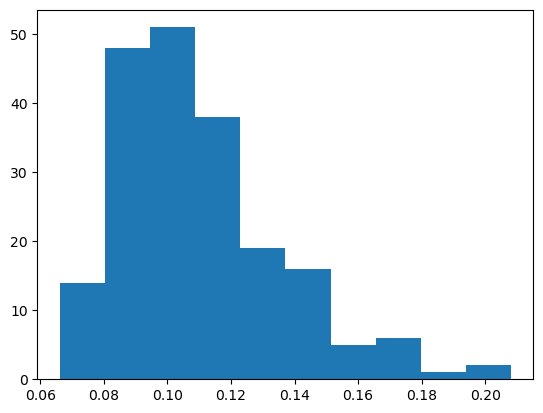

In [23]:
plt.hist(results)
plt.show()

In [24]:
results=np.array(results)
pop_size = len(results)
pop_5pc = int(pop_size*0.05)
sorted_result_args = np.argsort(results)
best_5p_res = results[sorted_result_args[:pop_5pc]]
worst_5p_res = results[sorted_result_args[-pop_5pc:]]

best_5p_lambda = lambda_sample_conditioned[sorted_result_args[:pop_5pc]]
worst_5p_lambda = lambda_sample_conditioned[sorted_result_args[-pop_5pc:]]

print(best_5p_res)
print(worst_5p_res)

[0.06625259 0.07053942 0.07053942 0.07053942 0.07276507 0.07276507
 0.07484407 0.07484407 0.07708333 0.07708333]
[0.16339869 0.16557734 0.16812227 0.16849015 0.17324561 0.17324561
 0.17802198 0.18061674 0.19512195 0.20805369]


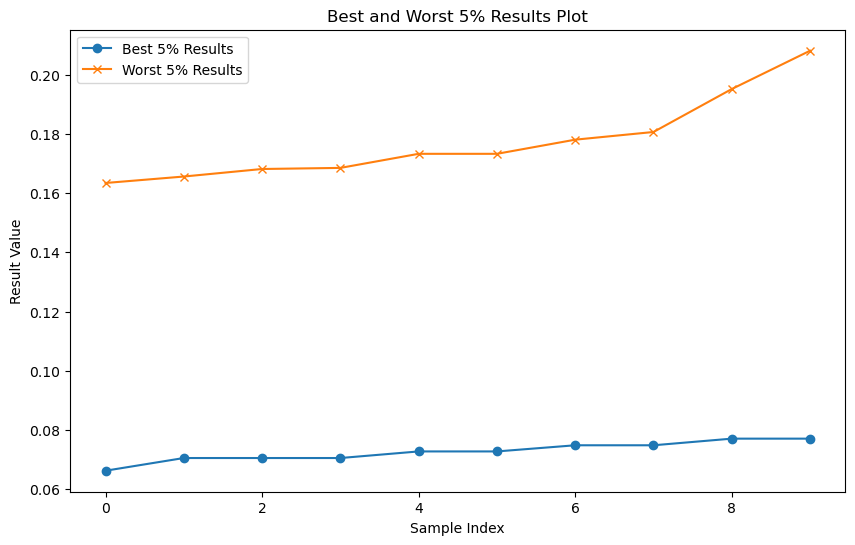

In [25]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the best 5% results
ax.plot(best_5p_res, label='Best 5% Results', marker='o', linestyle='-')

# Plot the worst 5% results
ax.plot(worst_5p_res, label='Worst 5% Results', marker='x', linestyle='-')

# Add labels and legend
ax.set_xlabel('Sample Index')
ax.set_ylabel('Result Value')
ax.set_title('Best and Worst 5% Results Plot')
ax.legend()

# Show the plot
plt.show()

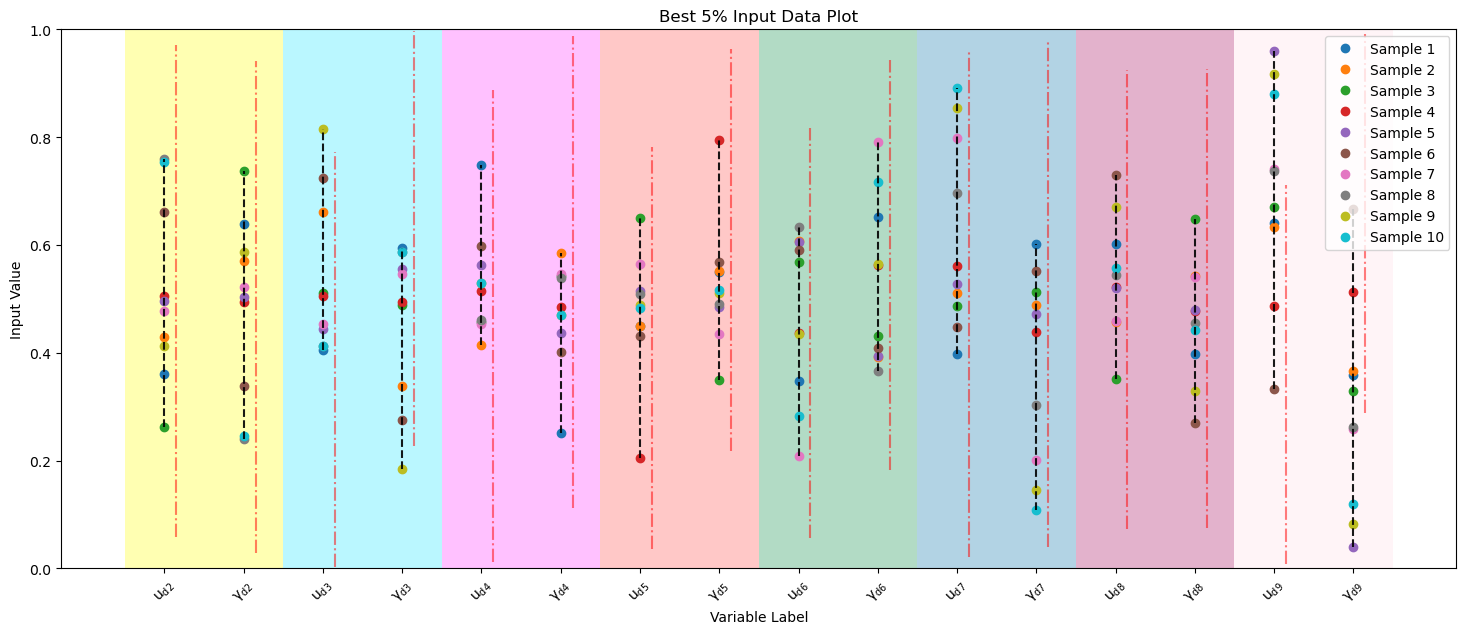

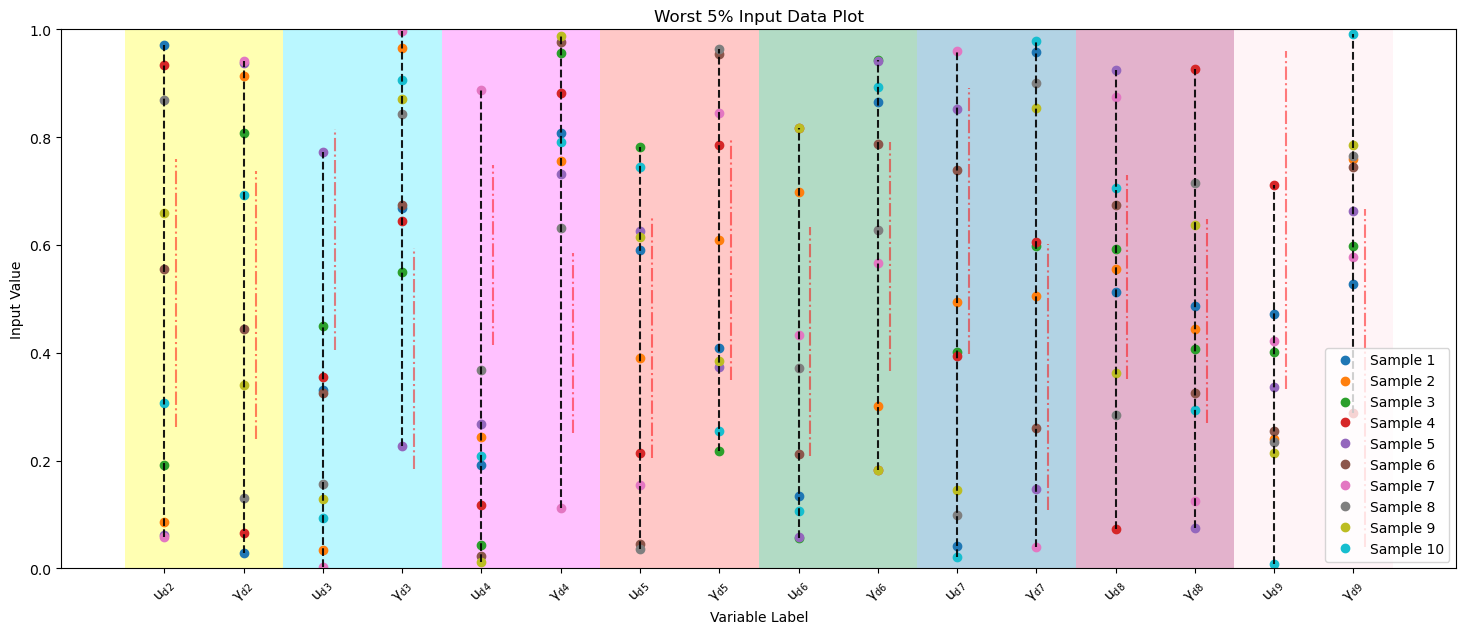

In [26]:
# %matplotlib qt
# Get the variable labels from the first sample (assuming all samples have the same variables)
variable_labels = [var for var in lambda_sample_conditioned.getDescription()]

variable_labels_tex = [f'${latex(sp.Symbol(var))}$' for var in lambda_sample_conditioned.getDescription()]


# Create separate figures and axes for the best and worst 5% plots
fig_best, ax_best = plt.subplots(figsize=(18, 7))
fig_worst, ax_worst = plt.subplots(figsize=(18, 7))

params = {'mathtext.default': 'regular' }  # Allows tex-style title & labels
plt.rcParams.update(params)

# Plot the best 5% input data
for i in range(len(best_5p_lambda)):
    ax_best.plot(best_5p_lambda[i], 'o',  label=f'Sample {i + 1}')

# Plot the worst 5% input data
for i in range(len(worst_5p_lambda)):
    ax_worst.plot(worst_5p_lambda[i], 'o', label=f'Sample {i + 1}')

# Rotate x-axis labels for better readability
ax_best.tick_params(axis='x', rotation=45)
ax_worst.tick_params(axis='x', rotation=45)

# Add labels and legend for the best 5% plot
ax_best.set_xlabel('Variable Label')
ax_best.set_ylabel('Input Value')
ax_best.set_title('Best 5% Input Data Plot')
ax_best.legend()

# Add labels and legend for the worst 5% plot
ax_worst.set_xlabel('Variable Label')
ax_worst.set_ylabel('Input Value')
ax_worst.set_title('Worst 5% Input Data Plot')
ax_worst.legend()

ax_worst.set_ylim(0,1)# Show the plots
ax_best.set_ylim(0,1)# Show the plots

# Define a color mapping dictionary for variables with the same index
color_mapping = {}
color_idx = 0
for var_label in variable_labels:
    index = re.match('.*?([0-9]+)$', str(var_label)).group(1)  # Extract the index part (e.g., '0')
    if index not in color_mapping:
        color_idx += 1
        color_mapping[index] = iota.hex_to_rgba(iota.color_palette_3[color_idx],as_float=True)


for i, var_label in enumerate(variable_labels):
    # Process best 5%
    var_data_best = [sample[variable_labels.index(var_label)] for sample in best_5p_lambda]
    var_index = int(re.match('.*?([0-9]+)$', str(var_label)).group(1))
    min_val_best = min(var_data_best)
    max_val_best = max(var_data_best)

    # Plot vertical lines for best 5%
    ax_best.axvline(x=i, ymin=min_val_best, ymax=max_val_best, color='black', linestyle='--', alpha=0.9)
    ax_best.axvspan(i - 0.5, i + 0.5, facecolor=color_mapping[str(var_index)], alpha=0.3)

    # Process worst 5%
    var_data_worst = [sample[variable_labels.index(var_label)] for sample in worst_5p_lambda]
    min_val_worst = min(var_data_worst)
    max_val_worst = max(var_data_worst)

    # Plot vertical lines for worst 5%
    ax_worst.axvline(x=i, ymin=min_val_worst, ymax=max_val_worst, color='black', linestyle='--', alpha=0.9)
    ax_worst.axvspan(i - 0.5, i + 0.5, facecolor=color_mapping[str(var_index)], alpha=0.3)

    # Plot vertical lines representing the span of the other axis (worst on best, best on worst)
    ax_best.axvline(x=i + 0.15, ymin=min_val_worst, ymax=max_val_worst, color='red', linestyle='dashdot', alpha=0.5, linewidth=1.5)
    ax_worst.axvline(x=i + 0.15, ymin=min_val_best, ymax=max_val_best, color='red', linestyle='dashdot', alpha=0.5, linewidth=1.5)


# Set the x-axis ticks and labels
ax_best.set_xticks(list(range(len(variable_labels))))
ax_best.set_xticklabels(variable_labels_tex)
ax_worst.set_xticks(list(range(len(variable_labels))))
ax_worst.set_xticklabels(variable_labels_tex)


#plt.tight_layout()
plt.show()